# Pierwszy i prawdopodobnie ostatni raz w życiu (trenujemy od podstaw konwolucyjną sieć neuronową)

In [1]:
import jax
import jax.numpy as jnp
from jax.random import PRNGKey as jkey

from training_cnn import *
from architectures import *

## Dane, dane, me królestwo za dane

***[RAPORT]*** Losowe elementy zbioru treningowego:

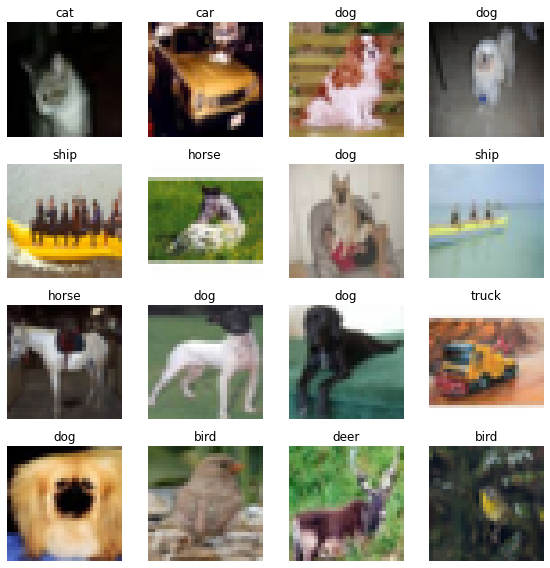

In [2]:
# Loading CIFAR10 dataset
(x_train, y_train), (x_test, y_test) = get_CIFAR10(jkey(42), 0.25)

# Plotting samples
plot_samples(x_train, y_train, (4, 4))

***[RAPORT]*** One hot encoding zrealizowałem z uzyciem funkcji `jax.nn.one_hot()`. Sprawdzam poprawność dla 10 pierwszych etykiet:

In [3]:
y_train_one_hot = jax.nn.one_hot(y_train, 10)
jnp.concatenate((jnp.expand_dims(y_train[:10], axis=-1), y_train_one_hot[:10]), axis=1)

DeviceArray([[3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
             [5., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
             [8., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
             [7., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
             [9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
             [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
             [5., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
             [4., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
             [8., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
             [8., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

## Minimalna architektura
### Min CNN

***[RAPORT]*** Skorzystałem z modułu `flax.linen` (u mnie jako `nn`), co pozwoliło mi na wysokopoziomowe sekwencyjne zdefiniowanie
architektury modelu. Dzięki temu mam dostęp do takich warstw jak `nn.Conv()`, `nn.Dense()`, `nn.max_pool()` oraz funkcji aktywacji
`nn.sigmoid()`, `nn.softmax()`. Mój model `MinCNN` składa się z `2 * (5 * 3 * 3 * 3 + 5) + (4 * 4 * 5 * 10 + 10) = 1090` parametrów.
Specjalnie nie uyłem tutaj na koniec funkcji aktywacji `softmax`, poniewaz kozystam z wbudowanej funkcji kosztu,
`optax.softmax_cross_entropy`, która stosuje softmax na logitach przed wyliczeniem entropii.

```python
class MinCNN(nn.Module):
    
  @nn.compact
  def __call__(self, batch):
    
    batch_size = batch.shape[0]
    x = batch / 255
    x = nn.Conv(features=5, kernel_size=(3, 3), padding='SAME')(x)
    x = nn.sigmoid(x)
    x = nn.Conv(features=5, kernel_size=(3, 3), padding='SAME')(x)
    x = nn.sigmoid(x)
    x = nn.max_pool(x, window_shape=(8, 8), strides=(8, 8))
    x = jnp.reshape(x, (batch_size, -1))
    x = nn.Dense(features=10)(x)
    # x = nn.softmax(x)
      
    return x
```

***[RAPORT]*** Prawdopodobieństwa poszczególnych klas zwracane przez niewytrenowany model dla pierwszych 5 przykładów:

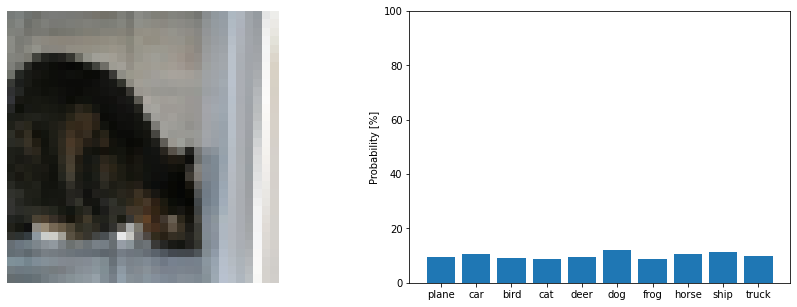

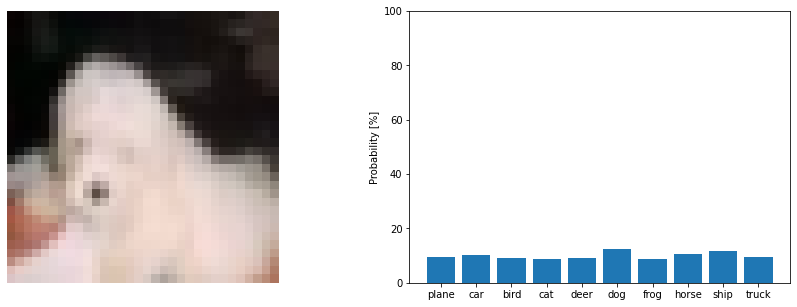

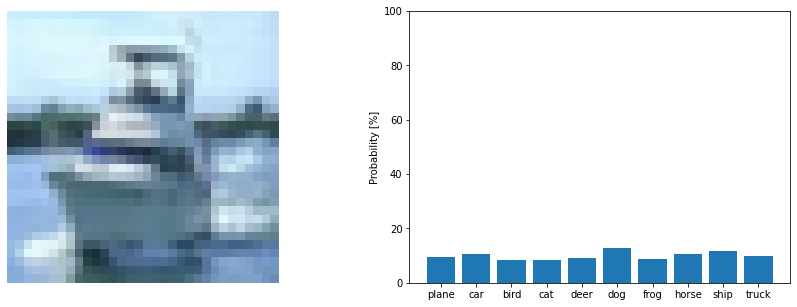

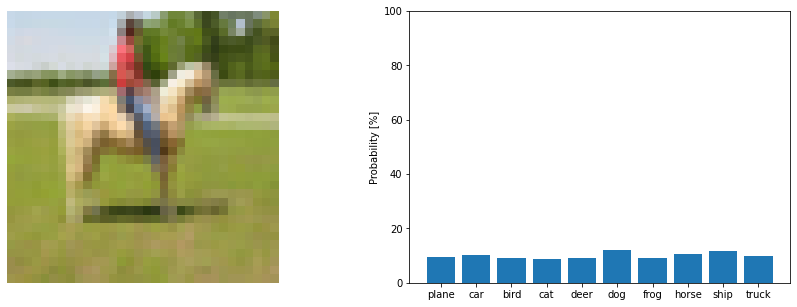

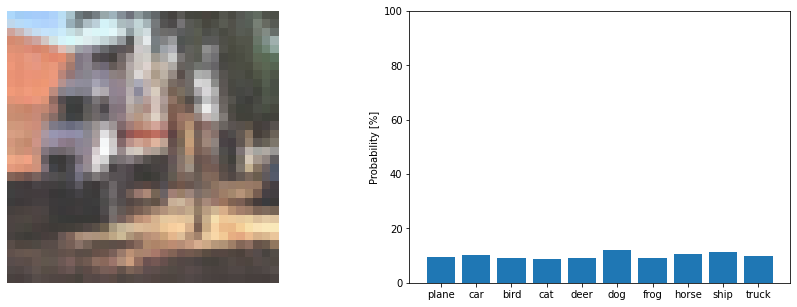

In [4]:
first_n = 5
for i in range(first_n):
    single_prediction(x_train[i], DUMMY_MODEL, verbose=True)

***[RAPORT]*** Przy treningu modelu inspirowałęm się [tutorialem flax](https://flax.readthedocs.io/en/latest/getting_started.html).
Skorzystałem z takich elementów jak `flax.training.train_state.TrainState()` który pozwala w łatwy sposób na funkcyjną implementację
treningu, co jest zgodne z filozofią *JAX*. Jako optymalizatora uzyłem `optax.sgd`. Trening zaimplementowałem w postaci 2 funkcji.
Funkcja `train_and_eval()` iteruje po epokach wywołując funkcję `train_epoch()`, zbiera dane metryki, zapisuje logi i checkpointy.
Z kolei funkcja `train_epoch()` to główna oś treningu i jej kod zamieszczam poniej:

```python
def train_epoch(
	state: TrainState,
	x_train: Array,
	y_train: Array,
	batch_size: int,
	perm_key: PRNGKey
) -> Tuple[TrainState, Scalar, Scalar]:

	n_samples = x_train.shape[0]
	steps_per_epoch = n_samples // batch_size

	perms = jax.random.permutation(perm_key, n_samples)[:steps_per_epoch * batch_size]
	perms = jnp.reshape(perms, (steps_per_epoch, batch_size))

	epoch_loss = []
	epoch_accuracy = []

	for perm in perms:

		x_batch = x_train[perm, ...]
		y_batch = y_train[perm, ...]
		grads, loss, accuracy = apply_model(state, x_batch, y_batch)
		state = update_model(state, grads)
		epoch_loss.append(loss)
		epoch_accuracy.append(accuracy)
	
	return state, np.mean(epoch_loss), np.mean(epoch_accuracy)
```

***[RAPORT]*** Model o minimalnej architekturze wytrenował się w `28m 55.3s`. Ponizej metryki ukazujące przebieg treningu:

![](results/min_cnn/metrices_150.png)

***[RAPORT]*** A tutaj prawdopodobieństwa przynalezności do klas dla pierwszych 5 przykładów według powyzszego modelu:

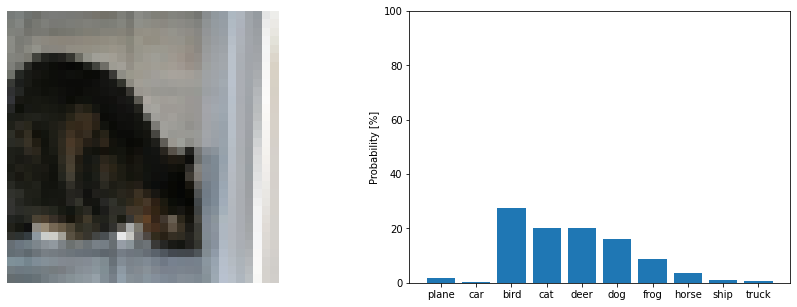

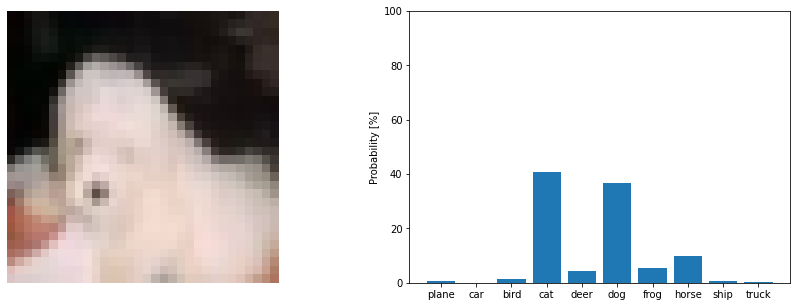

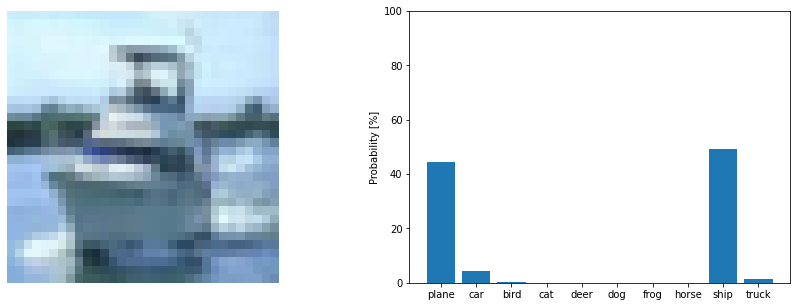

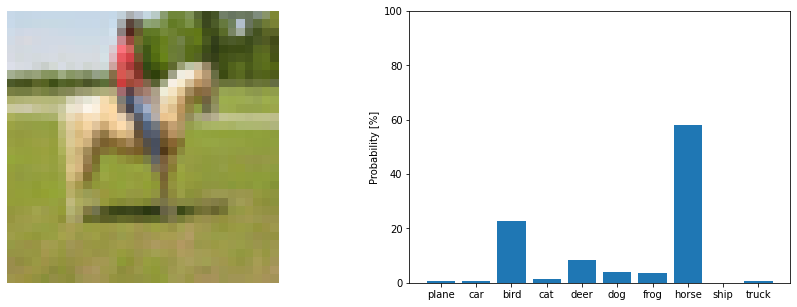

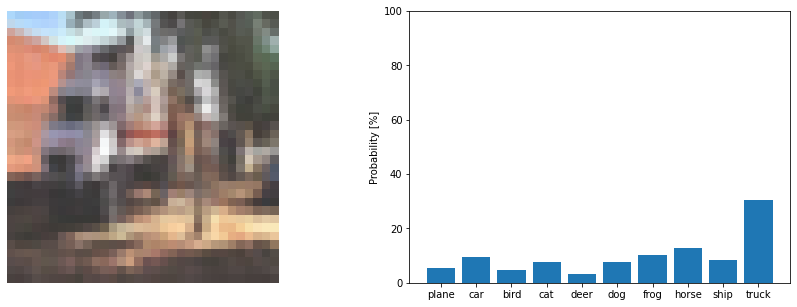

In [5]:
for i in range(first_n):
    single_prediction(x_train[i], MIN_CNN_MODEL, verbose=True)

## What? NETWORK is evolving!

### Min CNN Plus

***[RAPORT]*** Model ze zwiększoną liczbą filtrów z 5 do 20 wytrenował się w `brak danych`*. 
Po 150 epokach osiągneliśmy accuracy ok `60%` z tendencją wzrostową, czyli mozna by było kontynuować trening by uzyskać wyzszy wynik
bez overfitingu. liczba parametrów zwiększyła się 4-krotnie. Ponizej metryki ukazujące przebieg treningu:

![](results/min_cnn_plus/metrices_150.png)

### Double Block CNN

***[RAPORT]*** Blok konwolucyjny z aktywacją relu:
```python
def conv_block(x: Array, features: int) -> Array:

    x = nn.Conv(features=features, kernel_size=(3, 3), padding='SAME')(x)
    x = nn.relu(x)
    x = nn.Conv(features=features, kernel_size=(3, 3), padding='SAME')(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

    return x
```
***[RAPORT]*** Zmodyfikowany model:
```python
class DoubleBlockCNN(nn.Module):
    
    @nn.compact
    def __call__(self, batch: Array):
        
        batch_size = batch.shape[0]
        x = batch / 255
        x = conv_block(x, 20)
        x = conv_block(x, 40)
        x = jnp.reshape(x, (batch_size, -1))
        x = nn.Dense(features=10)(x)
        
        return x
```

***[RAPORT]*** Model dwu-blokowy wytrenował się w `brak danych`*. 
Po 147** epokach osiągneliśmy na zbiorze walidacyjnym accuracy ok `70%`. Wystąpił lekki overfitting, poniewaz loss mocno uciekł do góry,
jednak accuracy nie zmniejszyło się znacząco. (*Loss* na zbiorze walidacyjnym doszedł do wartości ok `3.7`, jednak wartośc nie zmiesciła
sie na wykresie)
Ponizej metryki ukazujące przebieg treningu:

![](results/double_block_cnn/metrices_147.png)

### Quad Block CNN

***[RAPORT]*** Model cztero-blokowy wytrenował się w `brak danych`*. 
Po 98** epokach osiągneliśmy na zbiorze walidacyjnym accuracy ok `69%`. Tu równierz wystąpił lekki ovefitting. (*Loss* na zbiorze
walidacyjnym doszedł do wartości ok `3.3`, jednak wartośc nie zmiesciła sie na wykresie)
Ponizej metryki ukazujące przebieg treningu:

![](results/quad_block_cnn/metrices_98.png)

### Batch Norm CNN

***[RAPORT]*** Dodanie warstwy normalizującej `nn.BatchNorm()` wprowadziłem poprzez modyfikację funkcji tworzącej blok konwolucyjny:
```python
def conv_block_with_bn(x: Array, features: int, training: bool) -> Array:

    x = nn.Conv(features=features, kernel_size=(3, 3), padding='SAME')(x)
    x = nn.BatchNorm(use_running_average=not training)(x)
    x = nn.relu(x)
    x = nn.Conv(features=features, kernel_size=(3, 3), padding='SAME')(x)
    x = nn.BatchNorm(use_running_average=not training)(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

    return x
```
Jednak oprócz tego prostego zabiegu, musiałem zmodyfikowac implementację funkcji `apply_model()`, która teraz, oprócz **gradientu**,
aktualnej wartości **loss** oraz **accuracy**, zwraca równiez stan ze zmodyfikowanym polem `batch_stats`, które estymuje parametry
$\mu$ oraz $\sigma^2$ dla kadej z warstw. Dodatkowo, mamy flagę `training`, która mówi czy mamy do czynienia z treningiem czy z
ewaluacją modelu.

***[RAPORT]*** Model z zastosowaniem *Batch Normalization* wytrenował się w `2h 49min 8s`. 
Po 150 epokach osiągneliśmy na zbiorze walidacyjnym accuracy ok `75%`. Tu równierz wystąpił lekki ovefitting, Loss w okolicach 10
epoki zaczął systematycznie rosnąc (lekko). *Batch Normalization* znacząco przyśpieszył trening, dodatkowo podczas eksperymentów mogłem
uzyc znacznie wyzszego *learning rate*, bez straty zdolności treningowej. 
Ponizej metryki ukazujące przebieg treningu:

![](results/batch_norm_cnn/metrices_150.png)

### Dropout CNN

***[RAPORT]*** Dodanie warstwy dropout `nn.Dropout()` wprowadziłem poprzez modyfikację funkcji tworzącej blok konwolucyjny:
```python
def conv_block_with_dropout(x: Array, features: int, dropout_rate: float, training: bool) -> Array:

    x = nn.Conv(features=features, kernel_size=(3, 3), padding='SAME')(x)
    x = nn.BatchNorm(use_running_average=not training)(x)
    x = nn.relu(x)
    x = nn.Conv(features=features, kernel_size=(3, 3), padding='SAME')(x)
    x = nn.BatchNorm(use_running_average=not training)(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Dropout(rate=dropout_rate, deterministic=not training)(x)

    return x
```
Musiałem równiez wykorzystac flagę `training`, oraz przekazywac funkcji `apply_fn` seed dla generatora PRNG uzywanego przez tą warstwę
zdeterminowania które neurony/jednostki mają się chwilowo wyłączyc.

***[RAPORT]*** Model z zastosowaniem *Batch Normalization* wytrenował się w `2h 57min 14s`. 
Po 150 epokach osiągneliśmy na zbiorze walidacyjnym accuracy ok `85%`. Overfitting został znacząco zredukowany, co pokazują ponizsze
metryki ukazujące przebieg treningu:

![](results/dropout_cnn/metrices_150.png)

## Mind the GAP!
### GAP CNN

***[Raport]*** Moja implementacja z uzyciem warst konwolucyjnych z biblioteki `flax` nie miała pierwotnie ograniczenia na rozdzielczośc
obrazu wejściowego, stąd nie musiałem nic zmieniac. Musiałem jednak zmodyfikowac dotychczasową architekturę (Dropout CNN), poprzez
zamianę ostatniej warstwy z `jnp.reshape()` na autorską warstwę `gap_pool()`. Warstwa autorska, poniewaz nie znalazłem w uzywanych
bibliotekach *GAP*, a implementacja sprowadziłą się do uzycia funkcji `max()` po odpowiednich wymiarach:
```python
def gap_pool(x):

    return jnp.max(x, axis=(-3, -2))


class GAPCNN(nn.Module):
    
    @nn.compact
    def __call__(self, batch: Array, training: bool):
        
        x = batch / 255
        x = conv_block_with_dropout(x, 20, 0.1, training)
        x = conv_block_with_dropout(x, 40, 0.2, training)
        x = conv_block_with_dropout(x, 80, 0.3, training)
        x = conv_block_with_dropout(x, 160, 0.4, training)
        x = gap_pool(x)
        x = nn.Dense(features=10)(x)
        
        return x
```

***[RAPORT]*** Model z zastosowaniem *GAP* wytrenował się w `2h 59min 50s`. 
Po 150 epokach osiągneliśmy na zbiorze walidacyjnym accuracy ok `85%` (bardzo zblizone do Dropout CNN).
Ponizej metryki ukazujące przebieg treningu:

![](results/gap_cnn/metrices_150.png)

#### Predykcja
***[RAPORT]*** Do testu działania zarówno modelu jak i GAP, wykorzystałem swojego kota - **Figę**:

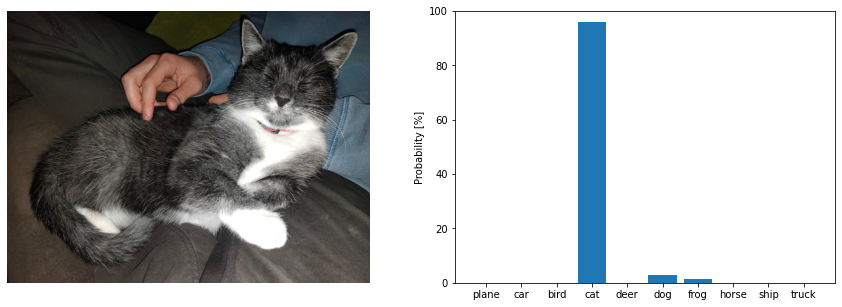

{'plane': DeviceArray(1.712226e-05, dtype=float32),
 'car': DeviceArray(0.00021748, dtype=float32),
 'bird': DeviceArray(0.000675, dtype=float32),
 'cat': DeviceArray(95.847115, dtype=float32),
 'deer': DeviceArray(0.00020075, dtype=float32),
 'dog': DeviceArray(2.7708027, dtype=float32),
 'frog': DeviceArray(1.3734031, dtype=float32),
 'horse': DeviceArray(0.0072101, dtype=float32),
 'ship': DeviceArray(5.9502383e-07, dtype=float32),
 'truck': DeviceArray(0.00034214, dtype=float32)}

In [6]:
single_prediction("images/figa.jpg", GAP_MODEL, verbose=True)

Model z `96%` dozą pewności stwierdził ze figa jest kotem. Moja mama tez jest tego zdania, co dowodzi ze zarówno GAP jak i model okazały
się sukcesem!

## Wnioski
* Przy 2 pierwszych architekturach, nie wystąpił overfitting, jednak nie osiągneliśmy zadowalająco wysokiej metryki *accuracy*, moe to siadczyc o tym ze architektura jest zbyt prosta aby model dopasował się do danych.
* Przy zastosowaniu bardziej skąplikowanej architektury (Double Block CNN oraz Quad Block CNN), sie zaczęła się trenowac coraz to szybciej, jednak wystąpił tutaj overfitting.
* Batch Normalization, to bardzo przydatna technika, która nie dośc, ze znacząco przyśpieszyłą trening, to jeszcze zadziałała w pewnym stopniu jak regularyzacja!
* Po dodaniu regularyzacji przez Dropout, uzyskaliśmy bardzo przyzwoity model, który osiągnął *accuracy* ~= `85%` na zbiorze walidacyjnym. W ksiązce pt. "The Alignment Problem" przeczytałem ze stosując dropout, nasza siec staje się przyblizeniem *Bayesowskiej Sieci Neuronowej*, która ładnie modeluje niepewnośc podczas inferencji, jednak trening takiej sieci jest piekielnie nieefektywny.
* W końcu, po Modyfikacji o GAP jakośc modelu nie pogorszyła się, a uzyskaliśmy mozliwośc wnioskowania o przykładach o dowolnej rozdzielczości!
### Rozwój modelu
MinCNN -> MinCNNPlus -> DoubleBlockCNN -> QuadBlockCNN -> BatchNormCNN -> DropoutCNN -> GAPCNN

![](results/min_cnn/metrices_150.png)
![](results/min_cnn_plus/metrices_150.png)
![](results/double_block_cnn/metrices_147.png)
![](results/quad_block_cnn/metrices_98.png)
![](results/batch_norm_cnn/metrices_150.png)
![](results/dropout_cnn/metrices_150.png)
![](results/gap_cnn/metrices_150.png)

## Bonus
### Predykcja *przypadków brzegowych*

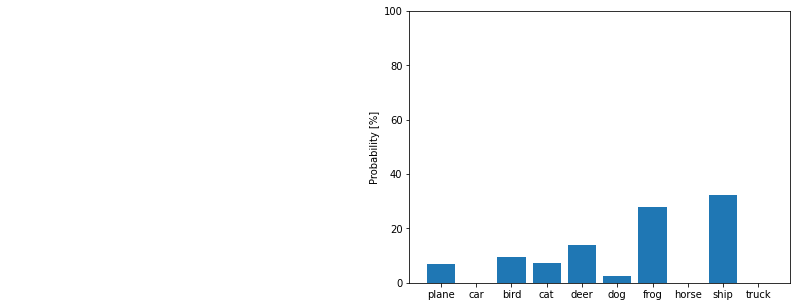

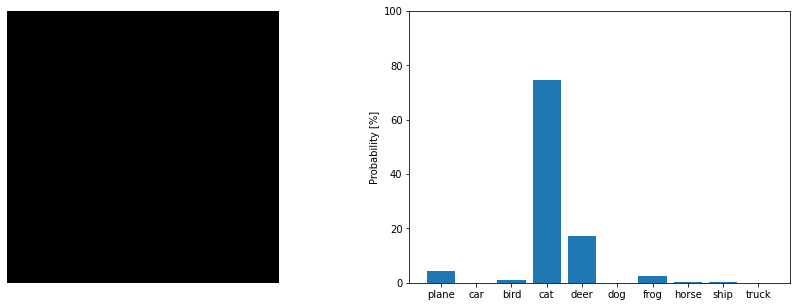

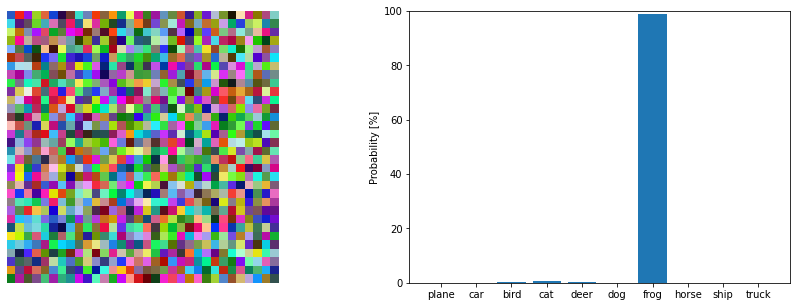

In [7]:
single_prediction(IMG_WHITE, GAP_MODEL, verbose=True)
single_prediction(IMG_BLACK, GAP_MODEL, verbose=True)
single_prediction(IMG_RANDOM, GAP_MODEL, verbose=True);

* Dla zdjęcia białego (jasnośc wszystkich kanałów 100%) model jest bardzo niezdecydowany, co moze swiadczyc o tym, ze wyłapał wiekszosc cech
* Na czarnym zdjęciu (jasnośc wszystkich kanałów 0%) model widzi kota
* Losowy szum często jest przez mój model jednoznacznie klasyfikowany jako zaba. Jest to całkiem niespodzewane. Czy wyjaśnieniem tego zjawiska mogłoby byc to ze zabe najcięzej było rozpoznac, stąd kiedy nie mamy zadnej cechy stajemy się zabą?

### Kilka moich przykładów

#### Cezar (pies)
Piesek przyjaciela

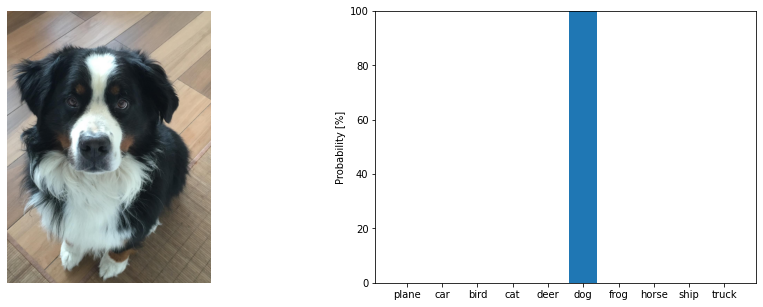

In [8]:
single_prediction("images/cezar.jpg", GAP_MODEL, verbose=True);

#### Elon Musk (Homo Sapiens)
Kategoria z poza domeny klasywikatora

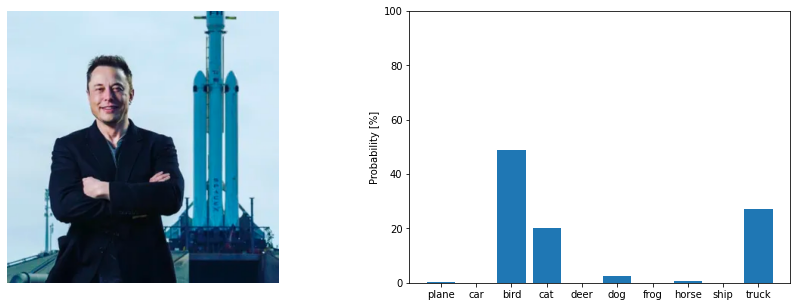

In [9]:
single_prediction("images/elon.png", GAP_MODEL, verbose=True);

#### Pomarańczowa zaba (Zaba)
Niekonwencjonalny okaz zaby

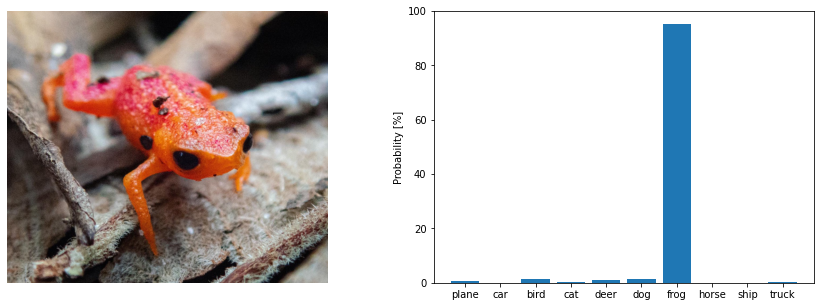

In [10]:
single_prediction("images/frog_orange.jpeg", GAP_MODEL, verbose=True);

#### Crazy Frog (Zaba)
Niekonwencjonalny okaz zaby nr 2

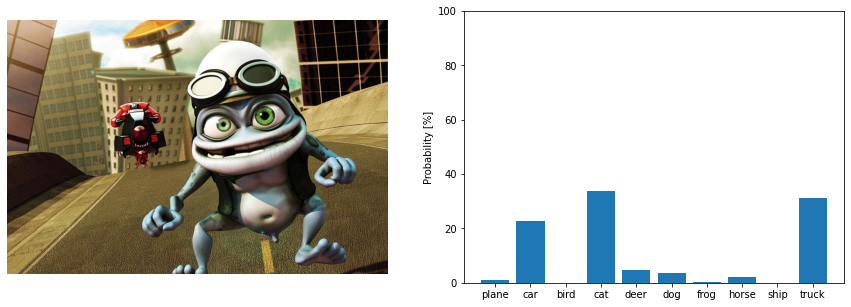

In [11]:
single_prediction("images/crazy-frog.jpeg", GAP_MODEL, verbose=True);

#### Labrador (Pies)
Kolejny ładny piesek, tym razem stock image

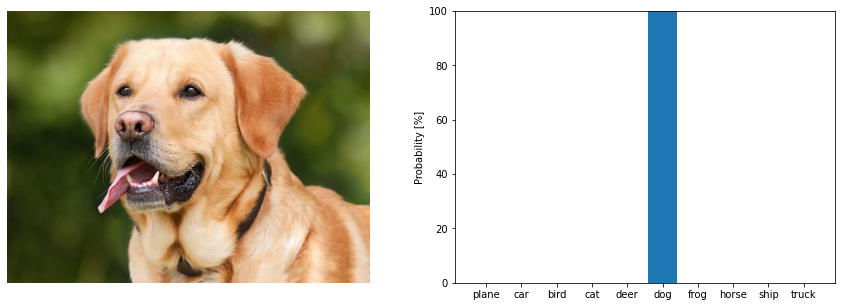

In [12]:
single_prediction("images/labrador.jpg", GAP_MODEL, verbose=True);

## Wyjaśnienia
\* Z powodu transferu treningu z notebooków *.ipynb* do skryptu *.py*, utraciłem automatyczne mierzenie czsu, którego zapomiałem dodac w początkowej fazie treningów.  
** Niektóre treningi zostały ucięte do mniejszej liczby epok niz 150, poniewaz przez złe ustawienia systemu, laptop zasypiał po pewnym czasie, co skutkowało błędem *bus-error* i urwaniem treningu... Jednak dzięki plotowaniu "na zywo" oraz checkpointom, byłem w stanie zaprezentowac dodtychczasowe wyniki, a ich analiza nie wskazywało aby w następnych epokach miała nastąpic nagła zmiana trendu. Zdecydowałem się zamieścic otrzymane, nieidealne wyiki, co mam nadzieje nie wpłynie negatywnie na ocenę.